## Mapping with GeoPandas

This is the accompanying notebook of this [blog entry](http://jose-coto.com/plotting-geopandas). Here we use the geopandas library to plot points got from Open Street Map to a shape file of the city of Lima. For more information, refer to the blog post.

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import geopandas.tools
from shapely.geometry import Point
import sqlite3
import seaborn as sns

In [2]:
#Getting bank data base
db = sqlite3.connect("/Users/Jose/Documents/Udacity/data_science/data_wrangling/Open_Street_project/Open_street_lima_project/lima_project")
#getting already stored shapefile
shp_lima = gp.GeoDataFrame.from_file('Lima_4326.shp')

In [3]:
#Simple map plot from shapefile
shp_lima.plot()

In [4]:
df_banks = pd.read_sql("""SELECT *
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as bank_vals 
             ON bank_vals.id=Node_tags.id, Nodes WHERE Node_tags.value="bank" and Nodes.id=Node_tags.id 
            """, con=db) 
df_banks["bank_names"] = df_banks["value"].iloc[:, 1]
df_banks = df_banks.drop(df_banks["value"], axis=1)

#Passing lan and lon to points
bank_points = df_banks[['lon', 'lat']].apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
geo_banks = gp.GeoDataFrame({"geometry": bank_points, "bank_names": df_banks["bank_names"]})

#You need to establish a coordinate system for the data you scraped.
geo_banks.crs = {'init': 'epsg:4326'}

(-12.600000000000001, -11.50000000000002)

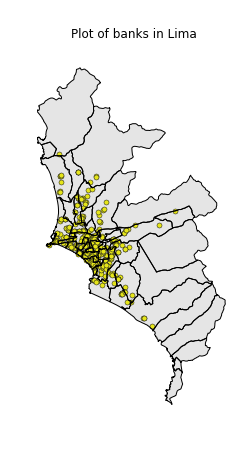

In [5]:
#Plotting location of all banks in Lima
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = shp_lima.plot(ax=ax, color='gray', alpha=0.2)
geo_banks.plot(ax=base, marker="o", mfc="yellow", markersize=5, markeredgecolor="black", zorder=0)
_ = ax.axis('off')
ax.set_title("Plot of banks in Lima")
ax.set_ylim(-12.600000000000001, -11.50000000000002)

In [6]:
#Performing Spatial Join
lima_banks = geopandas.tools.sjoin(geo_banks, shp_lima, how="right", op='intersects')

In [7]:
#Getting number of banks per district
num_banks_per_district = lima_banks.groupby("NOMBDIST").size()
num_banks_per_district = num_banks_per_district.to_frame(name="bank_num").reset_index()

#Establishing cut categories
num_banks_per_district["quant_cuts"] = pd.cut(num_banks_per_district["bank_num"], bins=[0, 10, 20, 30, 40, 100], 
              labels=["<=10", "<=20", "<=30","<=40", ">40"])
lima_bank_num = pd.merge(shp_lima, num_banks_per_district, on="NOMBDIST", how="right")

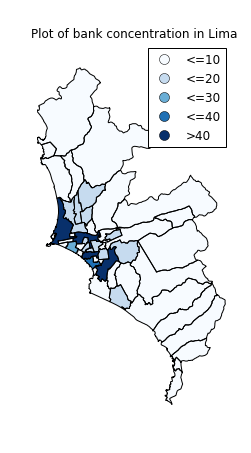

In [16]:
#Plotting concentration of banks in whole Lima
fig, ax = plt.subplots(1, figsize=(3.5,7))
lima_bank_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
ax.set_ylim(-12.600000000000001, -11.50000000000002)
_ = ax.axis('off')
ax.set_title("Plot of bank concentration in Lima")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, 0.5, 0.5, 0.5))

In [10]:
#Getting center of San Isidro
center_san_isidro = lima_bank_num[lima_bank_num["NOMBDIST"]=="SAN ISIDRO"]["geometry"].centroid

In [11]:
#Filtering Data set to get only the banks within certain distance from San Isidro
less_away = lima_bank_num["geometry"].distance(center_san_isidro.values[0]) < 0.1
central_areas = lima_bank_num[less_away]

(-77.200000000000003, -76.7)

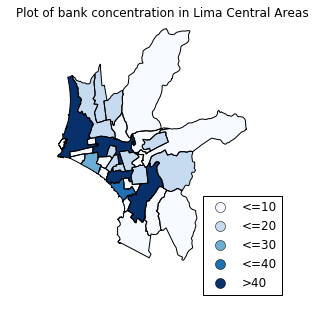

In [12]:
#Plotting banks within certain distance from San Isidro
fig, ax = plt.subplots(1, figsize=(4.5,5))
central_areas.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of bank concentration in Lima Central Areas")
ax.set_ylim(-12.30)
ax.set_xlim(ax.get_xlim()[0], -76.70)

In [45]:
us_data = pd.read_csv('usco2010.csv') 


In [46]:
counties = gp.read_file('UScounties.shp') 
counties["FIPS"] = counties["FIPS"].astype(int)


In [47]:
pd.merge(counties, us_data, on="FIPS")

,CNTY_FIPS,FIPS,NAME,STATE_FIPS,STATE_NAME,geometry,STATE,STATEFIPS,COUNTY,COUNTYFIPS,...,TO-WGWFr,TO-WGWSa,TO-WGWTo,TO-WSWFr,TO-WSWSa,TO-WSWTo,TO-WFrTo,TO-WSaTo,TO-WTotl,Unnamed: 117
0,077,27077,Lake of the Woods,27,Minnesota,"POLYGON ((-95.34283127277658 48.546679319076, ...",MN,27,Lake of the Woods County,77,...,0.40,0.00,0.40,0.56,0.0,0.56,0.96,0.00,0.96,NaN
1,019,53019,Ferry,53,Washington,POLYGON ((-118.8516288013387 47.94956368481996...,WA,53,Ferry County,19,...,4.03,0.00,4.03,2.29,0.0,2.29,6.32,0.00,6.32,NaN
2,065,53065,Stevens,53,Washington,"POLYGON ((-117.438831576286 48.04411548512263,...",WA,53,Stevens County,65,...,13.38,0.00,13.38,16.56,0.0,16.56,29.94,0.00,29.94,NaN
3,047,53047,Okanogan,53,Washington,"POLYGON ((-118.972093862835 47.93915200536639,...",WA,53,Okanogan County,47,...,34.03,0.00,34.03,64.67,0.0,64.67,98.70,0.00,98.70,NaN
4,051,53051,Pend Oreille,53,Washington,POLYGON ((-117.4385804303028 48.99991850672649...,WA,53,Pend Oreille County,51,...,2.60,0.00,2.60,1.40,0.0,1.40,4.00,0.00,4.00,NaN
5,021,16021,Boundary,16,Idaho,POLYGON ((-117.0291117188672 48.83807527955628...,ID,16,Boundary County,21,...,38.09,0.00,38.09,62.75,0.0,62.75,100.84,0.00,100.84,NaN
6,053,30053,Lincoln,30,Montana,POLYGON ((-116.0554974842291 48.20848379658699...,MT,30,Lincoln County,53,...,2.45,0.00,2.45,15.74,0.0,15.74,18.19,0.00,18.19,NaN
7,029,30029,Flathead,30,Montana,POLYGON ((-113.4736300572054 47.59757632110833...,MT,30,Flathead County,29,...,26.98,0.12,27.10,34.63,0.0,34.63,61.61,0.12,61.73,NaN
8,035,30035,Glacier,30,Montana,POLYGON ((-112.1827335389939 48.47116514063714...,MT,30,Glacier County,35,...,2.11,0.34,2.45,125.66,0.0,125.66,127.77,0.34,128.11,NaN
9,101,30101,Toole,30,Montana,POLYGON ((-111.4223100737647 48.21776252169813...,MT,30,Toole County,101,...,1.54,0.15,1.69,6.93,0.0,6.93,8.47,0.15,8.62,NaN


In [31]:
for i in counties["FIPS"]:
    if i in counties["FIPS"]:
        print "yes"
    

0       27077
1       53019
2       53065
3       53047
4       53051
5       16021
6       30053
7       30029
8       30035
9       30101
10      30051
11      30041
12      30091
13      38023
14      38013
15      38075
16      38009
17      38079
18      38095
19      38019
20      38067
21      27069
22      27135
23      30005
24      30071
25      30105
26      30019
27      53073
28      16017
29      38101
        ...  
3111     2170
3112     2270
3113     2050
3114     2020
3115     2122
3116     2070
3117     2164
3118     2100
3119     2110
3120     2150
3121     2220
3122     2280
3123     2130
3124     2201
3125     2013
3126     2016
3127    15005
3128    15007
3129    15003
3130    15009
3131    15001
3132    51143
3133    51590
3134     2261
3135     2282
3136     2232
3137     2290
3138     2240
3139     2068
3140     8014
Name: FIPS, dtype: int64

In [36]:
us_data["FIPS"]

0        1001
1        1003
2        1005
3        1007
4        1009
5        1011
6        1013
7        1015
8        1017
9        1019
10       1021
11       1023
12       1025
13       1027
14       1029
15       1031
16       1033
17       1035
18       1037
19       1039
20       1041
21       1043
22       1045
23       1047
24       1049
25       1051
26       1053
27       1055
28       1057
29       1059
        ...  
3194    72101
3195    72103
3196    72105
3197    72107
3198    72109
3199    72111
3200    72113
3201    72115
3202    72117
3203    72119
3204    72121
3205    72123
3206    72125
3207    72127
3208    72129
3209    72131
3210    72133
3211    72135
3212    72137
3213    72139
3214    72141
3215    72143
3216    72145
3217    72147
3218    72149
3219    72151
3220    72153
3221    78010
3222    78020
3223    78030
Name: FIPS, dtype: int64

In [70]:
import numpy as np
from tabulate import tabulate
old_df = pd.DataFrame({"a":np.arange(5), "b": np.arange(4,9)})
print tabulate(old_df, headers='keys', tablefmt='psql')

+----+-----+-----+
|    |   a |   b |
|----+-----+-----|
|  0 |   0 |   4 |
|  1 |   1 |   5 |
|  2 |   2 |   6 |
|  3 |   3 |   7 |
|  4 |   4 |   8 |
+----+-----+-----+


In [69]:
new_df = pd.DataFrame({"a":np.arange(7,8), "b": np.arange(10,11)})
new_df
print tabulate(new_df, headers='keys', tablefmt='psql')

+----+-----+-----+
|    |   a |   b |
|----+-----+-----|
|  0 |   7 |  10 |
+----+-----+-----+


In [73]:
old_df.update(new_df)

In [74]:
old_df
print tabulate(old_df, headers='keys', tablefmt='psql')

+----+-----+-----+
|    |   a |   b |
|----+-----+-----|
|  0 |   7 |  10 |
|  1 |   1 |   5 |
|  2 |   2 |   6 |
|  3 |   3 |   7 |
|  4 |   4 |   8 |
+----+-----+-----+
